In [1]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
from utils import parse_anno_file, create_mask_file, big_image_predict
from apex import amp

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# %matplotlib inline

31 26


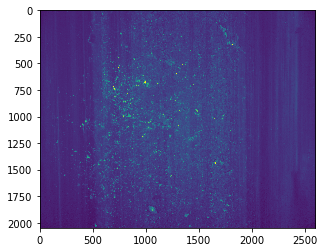

In [2]:
path_to_data = 'asbest'
anno_stones = parse_anno_file(os.path.join(path_to_data, 'images', 'annotation.xml'))
anno_tr_stones = parse_anno_file(os.path.join(path_to_data, 'tr_stones', 'annotation.xml'))
transporter_file = os.path.join('asbest', 'transporter', '2020.03.16', 'TRANS_11:28:05_16-03-2020_36.png')
plt.imshow(cv2.imread(transporter_file, cv2.IMREAD_UNCHANGED))
print(len(anno_stones), len(anno_tr_stones))

In [3]:
img_stones_shape = (int(anno_stones[0]['height']), int(anno_stones[0]['width']))
print('Размер кадра с одиночными камнями:')
print(img_stones_shape)
img_tr_stones_shape = (int(anno_tr_stones[0]['height']), int(anno_tr_stones[0]['width']))
print('Размер кадра с камнями на транспортерной ленте:')
print(img_tr_stones_shape)

Размер кадра с одиночными камнями:
(3456, 5184)
Размер кадра с камнями на транспортерной ленте:
(2048, 2592)


In [4]:
(img_stones_shape[0] // 2, img_stones_shape[1] // 3)

(1728, 1728)

In [5]:
# Деление на тренировочную и тестовую подвыборку одиночных камней
stones_valid_indexes = np.array([3, 7, 12], dtype=int)
stones_train_indexes = np.array(list(set(np.arange(len(anno_stones))) - set(stones_valid_indexes)), dtype=int)

In [6]:
img_sizes = [(4*224, 4*224)]#, (3*224, 3*224), (4*224, 4*224)]
# crop_sizes = [
#               None,
#               None,
#               None,
#              ]
crop_sizes = [ 
              (int(img_stones_shape[0] // 2), int(img_stones_shape[1] // 3)), 
            #  (int(img_stones_shape[0] // 2), int(img_stones_shape[1] // 3)),
             # (int(img_stones_shape[0] // 2), int(img_stones_shape[1] // 3)),
             ]
num_frames = [(500, 50)] #, (400, 50), (400, 50)]
batches = [2]#, 4, 2]
num_epochs = [500]#, 100, 100]

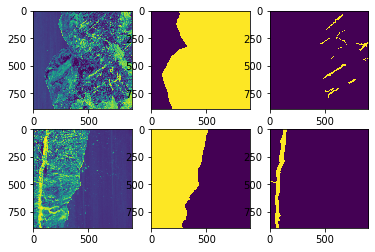

In [7]:
# Проверка картинок с одиночных камней
stones_train_data = Asbest_segmentation(np.array(anno_stones)[stones_train_indexes], transporter_file=transporter_file, 
                                     crop_size=crop_sizes[0], 
                                     img_size=img_sizes[0], 
                                     num_frames=10, normalize=True)
stones_valid_data = Asbest_segmentation(np.array(anno_stones)[stones_valid_indexes], transporter_file=transporter_file, 
                                     crop_size=crop_sizes[0], 
                                     img_size=img_sizes[0], 
                                     num_frames=10, normalize=True)
index = 1
plt.subplot(231)
plt.imshow(stones_train_data.images[index])
plt.subplot(232)
plt.imshow(stones_train_data.stone_masks[index])
plt.subplot(233)
plt.imshow(stones_train_data.asbest_masks[index])
plt.subplot(234)
plt.imshow(stones_valid_data.images[index])
plt.subplot(235)
plt.imshow(stones_valid_data.stone_masks[index])
plt.subplot(236)
plt.imshow(stones_valid_data.asbest_masks[index])

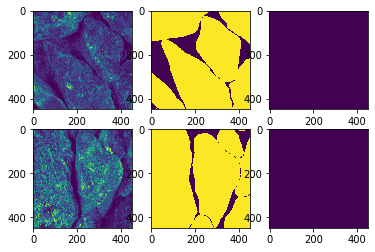

In [8]:
# Проверка картинок с транспортеной ленты
tr_stones_train_data = Asbest_segmentation(anno_tr_stones[:-5], 
                                           crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
                                           img_size=(448, 448), 
                                           num_frames=10, 
                                           normalize=True)
tr_stones_valid_data = Asbest_segmentation(anno_tr_stones[-5:], 
                                           crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
                                           img_size=(448, 448), 
                                           num_frames=10, 
                                           normalize=True)
index = 1
plt.subplot(231)
plt.imshow(tr_stones_train_data.images[index])
plt.subplot(232)
plt.imshow(tr_stones_train_data.stone_masks[index])
plt.subplot(233)
plt.imshow(tr_stones_train_data.asbest_masks[index])
plt.subplot(234)
plt.imshow(tr_stones_valid_data.images[index])
plt.subplot(235)
plt.imshow(tr_stones_valid_data.stone_masks[index])
plt.subplot(236)
plt.imshow(tr_stones_valid_data.asbest_masks[index])

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [10]:
from torch import nn
from torch import sigmoid
import segmentation_models_pytorch as smp


device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)

bce = smp.utils.losses.BCEWithLogitsLoss()
dice = smp.utils.losses.DiceLoss()
# criterion = nn.CrossEntropyLoss()
# criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-5}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [11]:
# from torchsummary import summary
# summary(model, (1, 224,224))

In [12]:
model, optimizer = amp.initialize(model, optimizer, opt_level='O2')
# model = model.to(device)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [13]:
def save_fig(crop_size, inp_size):
    files = ['asbest/tr_stones/9_12:40:22_05-03-2020_1.png',
             'asbest/tr_stones/1_11:32:12_16-03-2020_1.png',
             'asbest/tr_stones/22_13:21:36_16-03-2020_1.png',
             'asbest/tr_stones/20_12:23:59_16-03-2020_1.png',             
            ]

    full_image = None
    for i, file in enumerate(files):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        image, st_mask, asb_mask = big_image_predict(model, img, crop_size=crop_size, inp_size=inp_size, device=device)
        if full_image is None:
            full_image = np.concatenate((image, st_mask, asb_mask), axis=0)
        else:
            full_image = np.concatenate((full_image, np.concatenate((image, st_mask, asb_mask), axis=0)), axis=1)
    cv2.imwrite('graphics/' + datetime.now().strftime("%H:%M:%S") + '_segm_images.png', cv2.resize((full_image * 255).astype(np.uint8), (int(full_image.shape[1] / 8), int(full_image.shape[0] / 8))))
#     return full_image

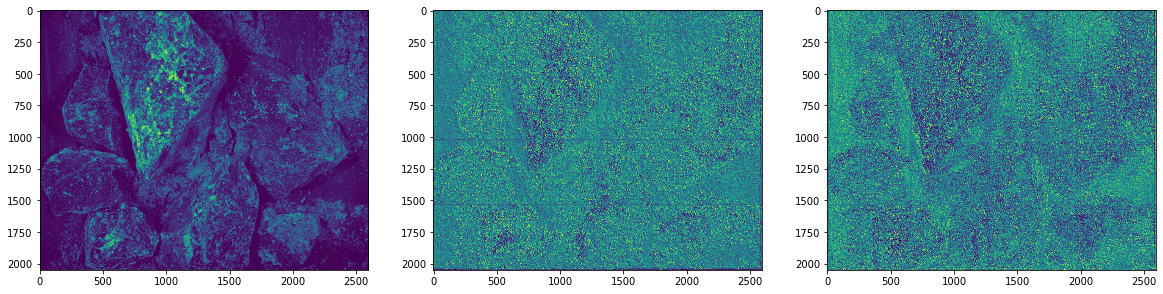

In [14]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
img, st, asb = big_image_predict(model, 
                                  img, 
                                  crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
                                  inp_size=(448,448),
                                  device=device
                                 )
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(st)
plt.subplot(133)
plt.imshow(asb)

In [15]:
from tqdm import trange, tqdm
from torch.utils.data import DataLoader

img_size=(2*448, 2*448)

tr_stones_train_data = Asbest_segmentation(anno_tr_stones[:-5], 
                                           crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
                                           img_size=img_size, 
                                           num_frames=1000, 
                                           normalize=True)
tr_stones_valid_data = Asbest_segmentation(anno_tr_stones[-5:], 
                                           crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
                                           img_size=img_size, 
                                           num_frames=200, 
                                           normalize=True)

tr_stones_train_loader = DataLoader(tr_stones_train_data, batch_size=8, shuffle=True, num_workers=2)
tr_stones_valid_loader = DataLoader(tr_stones_valid_data, batch_size=8, shuffle=True, num_workers=2)

epochs = 100

for epoch in range(epochs):
    
    if epoch == epochs - 1:
        leave = True
    else:
        leave = 0
    
    average_total_loss = AverageMeter()
    average_acc = AverageMeter()
    average_iou = AverageMeter()
    average_fscore = AverageMeter()
    average_total_val_loss = AverageMeter()
    average_val_acc = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(tr_stones_train_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Training', leave=leave) as t:
        t.postfix[0] = epoch + 1
        for data in tr_stones_train_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)[:,0:1,:,:]

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()

            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            average_iou.update(iou.data.item())
            average_fscore.update(fscore.data.item())
            
            t.postfix[1] = average_total_loss.average()
            t.postfix[2] = average_acc.average()
            t.postfix[3] = average_iou.average()
            t.postfix[4] = average_fscore.average()
            t.update()

    ## Validation
    val_average_total_loss = AverageMeter()
    val_average_acc = AverageMeter()
    val_average_iou = AverageMeter()
    val_average_fscore = AverageMeter()
    val_average_total_val_loss = AverageMeter()
    val_average_val_acc = AverageMeter()
    
    model.train(False)
    with tqdm(total=len(tr_stones_valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Validation', leave=leave) as t:
        t.postfix[0] = epoch + 1
        for data in tr_stones_valid_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

#             optimizer.zero_grad()
            outputs = model(inputs)[:,0:1,:,:]

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

#             loss.backward()
#             optimizer.step()

            val_average_total_loss.update(loss.data.item())
            val_average_acc.update(acc.data.item())
            val_average_iou.update(iou.data.item())
            val_average_fscore.update(fscore.data.item())
            
            t.postfix[1] = val_average_total_loss.average()
            t.postfix[2] = val_average_acc.average()
            t.postfix[3] = val_average_iou.average()
            t.postfix[4] = val_average_fscore.average()
            t.update()
        
    if (epoch + 1) % 5 == 0:
        save_fig(crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), inp_size=img_size)


Training epoch 65 | 44/125 00:24<00:42 | loss : 0.3375 | acc : 1.4148 | iou: 0.9738 | fscore: 0.9867 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Training epoch 84 | 116/125 01:03<00:04 | loss : 0.3326 | acc : 1.4442 | iou: 0.9774 | fscore: 0.9886

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Training epoch 99 | 98/125 00:53<00:14 | loss : 0.3294 | acc : 1.4613 | iou: 0.9792 | fscore: 0.9895 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


Training epoch 100 | 125/125 01:08<00:00 | loss : 0.3283 | acc : 1.4384 | iou: 0.9796 | fscore: 0.9897
Validation epoch 100 | 25/25 00:05<00:00 | loss : 0.3549 | acc : 1.6984 | iou: 0.9317 | fscore: 0.9646


In [16]:
torch.save(model.state_dict(), 'stone_segmentation.pth')

In [15]:
model.load_state_dict(torch.load('asbest_segmentation.pth'))
model.eval();

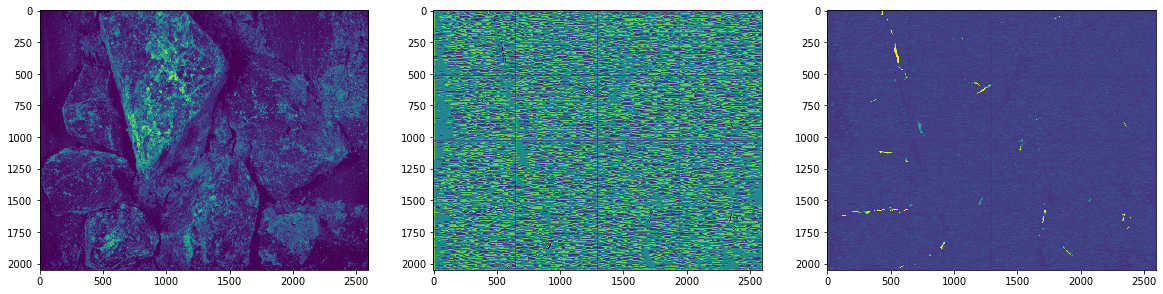

In [16]:
img_size=(2*448, 2*448)

img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
img, st, asb =big_image_predict(model, 
                                  img, 
                                  crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(st)
plt.subplot(133)
plt.imshow(asb)

In [17]:
from tqdm import trange, tqdm
from torch.utils.data import DataLoader

for epochs, batch, crop_size, img_size, num_frame in zip(num_epochs, batches, crop_sizes, img_sizes, num_frames):

    stones_train_data = Asbest_segmentation(np.array(anno_stones)[stones_train_indexes], 
                                     transporter_file=transporter_file, 
                                     crop_size=crop_size, 
                                     img_size=img_size, 
                                     num_frames=num_frame[0], normalize=True)
    stones_valid_data = Asbest_segmentation(np.array(anno_stones)[stones_valid_indexes], 
                                     transporter_file=transporter_file, 
                                     crop_size=crop_size, 
                                     img_size=img_size, 
                                     num_frames=num_frame[1], normalize=True)
    
    stones_train_loader = DataLoader(stones_train_data, batch_size=batch, shuffle=True, num_workers=4)
    stones_valid_loader = DataLoader(stones_valid_data, batch_size=batch, shuffle=True, num_workers=1)
    
    for epoch in range(epochs):

        if epoch == epochs - 1:
            leave = True
        else:
            leave = 0

        average_total_loss = AverageMeter()
        average_iou_stones = AverageMeter()
        average_fscore_stones = AverageMeter()
        average_iou_asbest = AverageMeter()
        average_fscore_asbest = AverageMeter()

        model.train(True)
        with tqdm(total=len(stones_train_loader), 
                  bar_format='{desc} epoch {postfix[0]} ' + 
                  '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
                  '| loss : {postfix[1]:>2.4f} ' +  
                  '| iou_st: {postfix[2]:>2.4f} ' + 
                  '| fscore_st: {postfix[3]:>2.4f}'+ 
                  '| iou_asb: {postfix[4]:>2.4f} ' + 
                  '| fscore_asb: {postfix[5]:>2.4f}', 
                  postfix=[0, 0, 0, 0, 0, 0], desc = 'Training', leave=leave) as t:
            t.postfix[0] = epoch + 1
            for data in stones_train_loader:

#                 torch.cuda.empty_cache()
                inputs, st_masks, asb_masks = data
                masks = torch.cat((st_masks, asb_masks), axis=1)

                inputs=inputs.to(device).float()
                masks=masks.to(device).float()

                optimizer.zero_grad()
                outputs = model(inputs)

#                 loss = 0 * (0.7 * bce(outputs[:,0:1,:,:], masks[:,0:1,:,:]) + 0.3 * dice(outputs[:,0:1,:,:], masks[:,0:1,:,:])) + \
                loss = 0.7 * bce(outputs[:,1:,:,:], masks[:,1:,:,:]) + 0.3 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])
                
                iou_stones = metrics[0](outputs[:,0:1,:,:], masks[:,0:1,:,:])
                fscore_stones = metrics[1](outputs[:,0:1,:,:], masks[:,0:1,:,:])
                iou_asbest = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
                fscore_asbest = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                optimizer.step()

                average_total_loss.update(loss.data.item())
                average_iou_stones.update(iou_stones.data.item())
                average_fscore_stones.update(fscore_stones.data.item())
                average_iou_asbest.update(iou_asbest.data.item())
                average_fscore_asbest.update(fscore_asbest.data.item())

                t.postfix[1] = average_total_loss.average()
                t.postfix[2] = average_iou_stones.average()
                t.postfix[3] = average_fscore_stones.average()
                t.postfix[4] = average_iou_asbest.average()
                t.postfix[5] = average_fscore_asbest.average()
                t.update()

        ## Validation
        val_average_total_loss = AverageMeter()
        val_average_iou_stones = AverageMeter()
        val_average_fscore_stones = AverageMeter()
        val_average_iou_asbest = AverageMeter()
        val_average_fscore_asbest = AverageMeter()


        model.train(False)
        with tqdm(total=len(stones_valid_loader), 
                  bar_format='{desc} epoch {postfix[0]} ' + 
                  '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
                  '| loss : {postfix[1]:>2.4f} ' + 
                  '| iou_st: {postfix[2]:>2.4f} ' + 
                  '| fscore_st: {postfix[3]:>2.4f}' + 
                  '| iou_asb: {postfix[4]:>2.4f} ' + 
                  '| fscore_asb: {postfix[5]:>2.4f}', 
                  postfix=[0, 0, 0, 0, 0, 0], desc = 'Validation', leave=leave) as t:
            t.postfix[0] = epoch + 1
            for data in stones_valid_loader:

#                 torch.cuda.empty_cache()
                inputs, st_masks, asb_masks = data
                masks = torch.cat((st_masks, asb_masks), axis=1)

                inputs=inputs.to(device).float()
                masks=masks.to(device).float()

                outputs = model(inputs)

#                 loss = 0.2 * (0.7 * bce(outputs[:,0:1,:,:], masks[:,0:1,:,:]) + 0.3 * dice(outputs[:,0:1,:,:], masks[:,0:1,:,:])) + \
#                 0.8 * (0.7 * bce(outputs[:,1:,:,:], masks[:,1:,:,:]) + 0.3 * dice(outputs[:,1:,:,:], masks[:,1:,:,:]))
                loss = 0.7 * bce(outputs[:,1:,:,:], masks[:,1:,:,:]) + 0.3 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])
                
                iou_stones = metrics[0](outputs[:,0:1,:,:], masks[:,0:1,:,:])
                fscore_stones = metrics[1](outputs[:,0:1,:,:], masks[:,0:1,:,:])
                iou_asbest = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
                fscore_asbest = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

                val_average_total_loss.update(loss.data.item())
                val_average_iou_stones.update(iou_stones.data.item())
                val_average_fscore_stones.update(fscore_stones.data.item())
                val_average_iou_asbest.update(iou_asbest.data.item())
                val_average_fscore_asbest.update(fscore_asbest.data.item())

                t.postfix[1] = val_average_total_loss.average()
                t.postfix[2] = val_average_iou_stones.average()
                t.postfix[3] = val_average_fscore_stones.average()
                t.postfix[4] = val_average_iou_asbest.average()
                t.postfix[5] = val_average_fscore_asbest.average()
                t.update()
                
        if (epoch + 1) % 10 == 0:
            save_fig(crop_size=(1024, 1296), inp_size=img_size)

Training epoch 34 | 31/250 00:23<02:40 | loss : 0.7898 | iou_st: 0.2637 | fscore_st: 0.4163| iou_asb: 0.6747 | fscore_asb: 0.7765 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Training epoch 37 | 215/250 02:42<00:26 | loss : 0.7777 | iou_st: 0.2586 | fscore_st: 0.4097| iou_asb: 0.7014 | fscore_asb: 0.7926IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 105 | 157/250 01:59<01:08 | loss : 0.7577 | iou_st: 0.2567 | fscore_st: 0.4063| iou_asb: 0.7449 | fscore_asb: 0.8112

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


Training epoch 117 | 139/250 01:45<01:24 | loss : 0.7614 | iou_st: 0.2511 | fscore_st: 0.3999| iou_asb: 0.7620 | fscore_asb: 0.8268IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 152 | 32/250 00:24<02:40 | loss : 0.7484 | iou_st: 0.2430 | fscore_st: 0.3885| iou_asb: 0.8089 | fscore_asb: 0.8665 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 156 | 247/250 03:07<00:02 | loss : 0.7452 | iou_st: 0.2458 | fscore_st: 0.3929| iou_asb: 0.8019 | fscore_asb: 0.8600IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 187 | 226/250 02:51<00:17 | loss : 0.7377 | iou_st: 0.2378 | fscore_st: 0.3830| iou_asb: 0.8090 | fscore_asb: 0.8631

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


Training epoch 193 | 148/250 01:52<01:15 | loss : 0.7329 | iou_st: 0.2305 | fscore_st: 0.3727| iou_asb: 0.8224 | fscore_asb: 0.8799

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Validation epoch 196 | 9/25 00:01<00:02 | loss : 0.7575 | iou_st: 0.2552 | fscore_st: 0.4065| iou_asb: 0.4147 | fscore_asb: 0.5753 IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 230 | 70/250 00:53<02:12 | loss : 0.7301 | iou_st: 0.2268 | fscore_st: 0.3678| iou_asb: 0.8298 | fscore_asb: 0.8861 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Training epoch 236 | 14/250 00:10<02:59 | loss : 0.7368 | iou_st: 0.2193 | fscore_st: 0.3589| iou_asb: 0.7503 | fscore_asb: 0.7990 IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 266 | 142/250 01:47<01:19 | loss : 0.7214 | iou_st: 0.2095 | fscore_st: 0.3450| iou_asb: 0.8206 | fscore_asb: 0.8674

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 276 | 45/250 00:34<02:35 | loss : 0.7086 | iou_st: 0.2157 | fscore_st: 0.3540| iou_asb: 0.8115 | fscore_asb: 0.8575 IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 280 | 121/250 01:31<01:34 | loss : 0.7119 | iou_st: 0.2102 | fscore_st: 0.3461| iou_asb: 0.8380 | fscore_asb: 0.8884

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 292 | 120/250 01:31<01:35 | loss : 0.7067 | iou_st: 0.2119 | fscore_st: 0.3480| iou_asb: 0.8430 | fscore_asb: 0.8903

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 305 | 4/250 00:03<03:32 | loss : 0.7147 | iou_st: 0.1897 | fscore_st: 0.3187| iou_asb: 0.7097 | fscore_asb: 0.7292  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 320 | 195/250 02:27<00:40 | loss : 0.7033 | iou_st: 0.1985 | fscore_st: 0.3299| iou_asb: 0.8290 | fscore_asb: 0.8702

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 322 | 181/250 02:17<00:50 | loss : 0.6992 | iou_st: 0.1987 | fscore_st: 0.3300| iou_asb: 0.8504 | fscore_asb: 0.8930

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


Training epoch 331 | 194/250 02:27<00:41 | loss : 0.7000 | iou_st: 0.1984 | fscore_st: 0.3294| iou_asb: 0.8301 | fscore_asb: 0.8725

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


Training epoch 337 | 149/250 01:52<01:14 | loss : 0.7003 | iou_st: 0.1989 | fscore_st: 0.3304| iou_asb: 0.8405 | fscore_asb: 0.8805

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Training epoch 365 | 105/250 01:19<01:47 | loss : 0.6940 | iou_st: 0.1955 | fscore_st: 0.3255| iou_asb: 0.8259 | fscore_asb: 0.8660

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 379 | 168/250 02:07<01:00 | loss : 0.6900 | iou_st: 0.1924 | fscore_st: 0.3213| iou_asb: 0.8352 | fscore_asb: 0.8778

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 389 | 152/250 01:55<01:12 | loss : 0.6821 | iou_st: 0.1940 | fscore_st: 0.3232| iou_asb: 0.8652 | fscore_asb: 0.9055

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Training epoch 389 | 177/250 02:14<00:55 | loss : 0.6839 | iou_st: 0.1915 | fscore_st: 0.3195| iou_asb: 0.8569 | fscore_asb: 0.8964IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 426 | 118/250 01:29<01:37 | loss : 0.6777 | iou_st: 0.1939 | fscore_st: 0.3233| iou_asb: 0.8661 | fscore_asb: 0.9046

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


Training epoch 431 | 62/250 00:47<02:22 | loss : 0.6831 | iou_st: 0.1842 | fscore_st: 0.3095| iou_asb: 0.8476 | fscore_asb: 0.8814 IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 465 | 137/250 01:43<01:23 | loss : 0.6694 | iou_st: 0.1883 | fscore_st: 0.3157| iou_asb: 0.8628 | fscore_asb: 0.8992

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


Validation epoch 471 | 21/25 00:03<00:00 | loss : 0.6976 | iou_st: 0.2216 | fscore_st: 0.3624| iou_asb: 0.4451 | fscore_asb: 0.6038IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



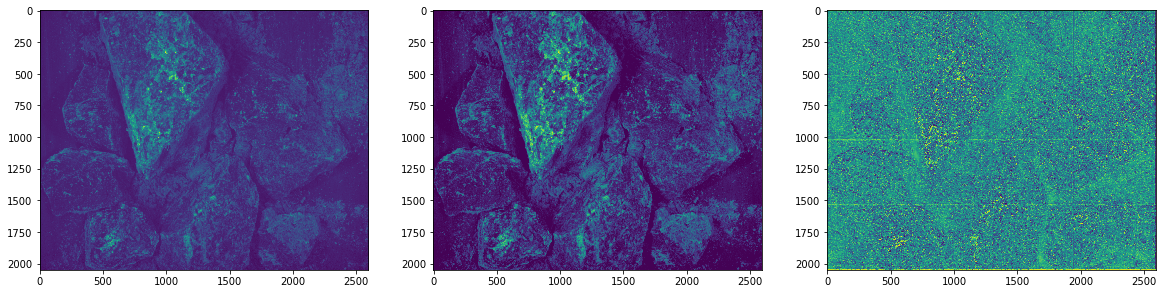

In [11]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/22_13:21:36_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/20_12:23:59_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (2*448,2*448), device=device)
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(mask)

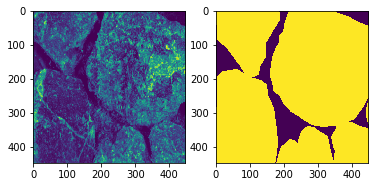

In [7]:
index = 73
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.stone_masks[index])

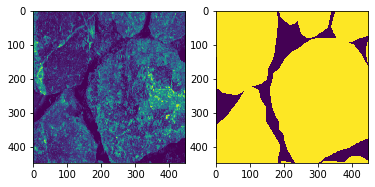

In [8]:
index = 31
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.stone_masks[index])

In [10]:
from torch import nn
from torch import sigmoid
import segmentation_models_pytorch as smp


device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, activation='sigmoid').to(device)

bce = smp.utils.losses.BCEWithLogitsLoss()
dice = smp.utils.losses.DiceLoss(activation='sigmoid')
# criterion = nn.CrossEntropyLoss()
# criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

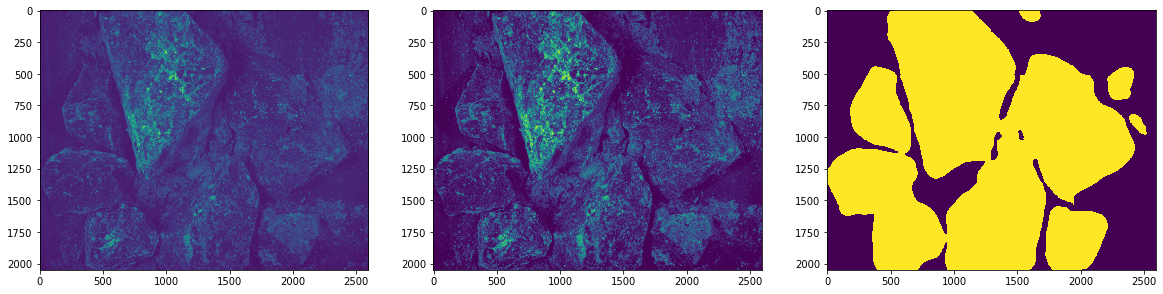

In [16]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (448,448), device=device)
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(mask > 0.95)

In [17]:
train_data = Asbest_segmentation(anno[:-5], crop_size=(img_shape[0] // 4, img_shape[1] // 4), img_size=(448, 448), num_frames=1000, normalize=True)
valid_data = Asbest_segmentation(anno[-5:], crop_size=(img_shape[0] // 4, img_shape[1] // 4), img_size=(448, 448), num_frames=200, normalize=True)

100%|██████████| 200/200 [00:23<00:00,  8.69it/s]


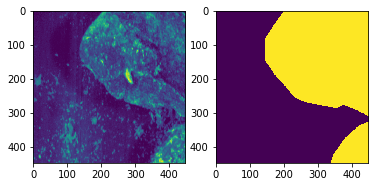

In [19]:
index = 73
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.stone_masks[index])

In [20]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True, num_workers=2)

In [21]:
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-5}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [29]:
from tqdm import trange, tqdm

epochs = 5

for epoch in range(epochs):
    
    average_total_loss = AverageMeter()
    average_acc = AverageMeter()
    average_iou = AverageMeter()
    average_fscore = AverageMeter()
    average_total_val_loss = AverageMeter()
    average_val_acc = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            average_iou.update(iou.data.item())
            average_fscore.update(fscore.data.item())
            
            t.postfix[1] = average_total_loss.average()
            t.postfix[2] = average_acc.average()
            t.postfix[3] = average_iou.average()
            t.postfix[4] = average_fscore.average()
            t.update()

    ## Validation
    val_average_total_loss = AverageMeter()
    val_average_acc = AverageMeter()
    val_average_iou = AverageMeter()
    val_average_fscore = AverageMeter()
    val_average_total_val_loss = AverageMeter()
    val_average_val_acc = AverageMeter()
    
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            val_average_total_loss.update(loss.data.item())
            val_average_acc.update(acc.data.item())
            val_average_iou.update(iou.data.item())
            val_average_fscore.update(fscore.data.item())
            
            t.postfix[1] = val_average_total_loss.average()
            t.postfix[2] = val_average_acc.average()
            t.postfix[3] = val_average_iou.average()
            t.postfix[4] = val_average_fscore.average()
            t.update()
#     model.train(False)
#     mask = predict(model, image)
#     mask = cv2.resize(mask, (1042, 719))
#     images = np.concatenate((cv2.cvtColor(cv2.resize(image, (1042, 719)), cv2.COLOR_RGB2GRAY), 255*mask), axis=1)
# #     images = cv2.resize(images, (1024, 1680))
#     cv2.imwrite(os.path.join('result', 'train.bmp'), images)
    
#     mask = predict(model, val_image)
#     mask = cv2.resize(mask, (1042, 719))
#     images = np.concatenate((cv2.cvtColor(cv2.resize(val_image, (1042, 719)), cv2.COLOR_RGB2GRAY), 255*mask), axis=1)
# #     images = np.concatenate((cv2.cvtColor(val_image, cv2.COLOR_RGB2GRAY), 255*(mask > threshold)), axis=1)
# #     images = cv2.resize(images, (1024, 1680))
#     cv2.imwrite(os.path.join('result', 'valid.bmp'), images)

Training epoch 1 | 125/125 01:16<00:00 | loss : 0.4299 | acc : 2.6585 | iou: 0.9157 | fscore: 0.9549
Validation epoch 1 | 25/25 00:15<00:00 | loss : 0.4250 | acc : 3.0736 | iou: 0.9487 | fscore: 0.9736
Training epoch 2 | 125/125 01:16<00:00 | loss : 0.4267 | acc : 2.6585 | iou: 0.9256 | fscore: 0.9609
Validation epoch 2 | 25/25 00:15<00:00 | loss : 0.4236 | acc : 3.0736 | iou: 0.9515 | fscore: 0.9751
Training epoch 3 | 125/125 01:16<00:00 | loss : 0.4262 | acc : 2.6585 | iou: 0.9270 | fscore: 0.9618
Validation epoch 3 | 25/25 00:15<00:00 | loss : 0.4240 | acc : 3.0736 | iou: 0.9506 | fscore: 0.9746
Training epoch 4 | 125/125 01:16<00:00 | loss : 0.4246 | acc : 2.6585 | iou: 0.9319 | fscore: 0.9644
Validation epoch 4 | 25/25 00:15<00:00 | loss : 0.4223 | acc : 3.0736 | iou: 0.9539 | fscore: 0.9764
Training epoch 5 | 125/125 01:16<00:00 | loss : 0.4245 | acc : 2.6585 | iou: 0.9336 | fscore: 0.9654
Validation epoch 5 | 25/25 00:15<00:00 | loss : 0.4225 | acc : 3.0736 | iou: 0.9542 | fscor

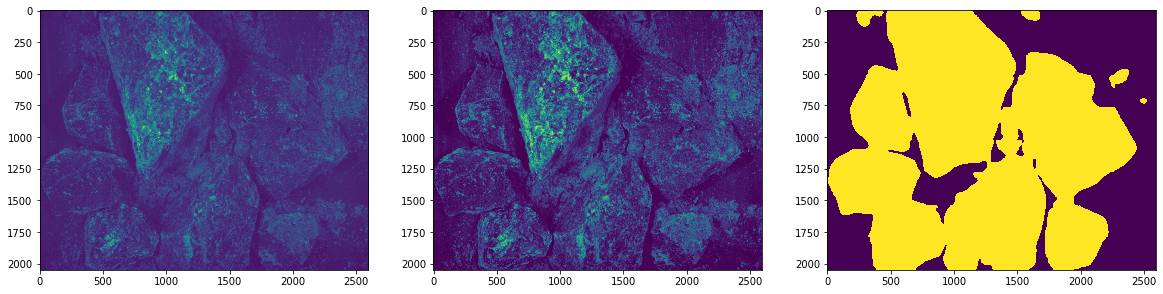

In [30]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 4, img.shape[0] // 4), inp_size = (448,448), device=device)
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(mask > 0.95)

In [5]:
model_load = torch.load('stone_segmentation.pth');
model_load.eval();

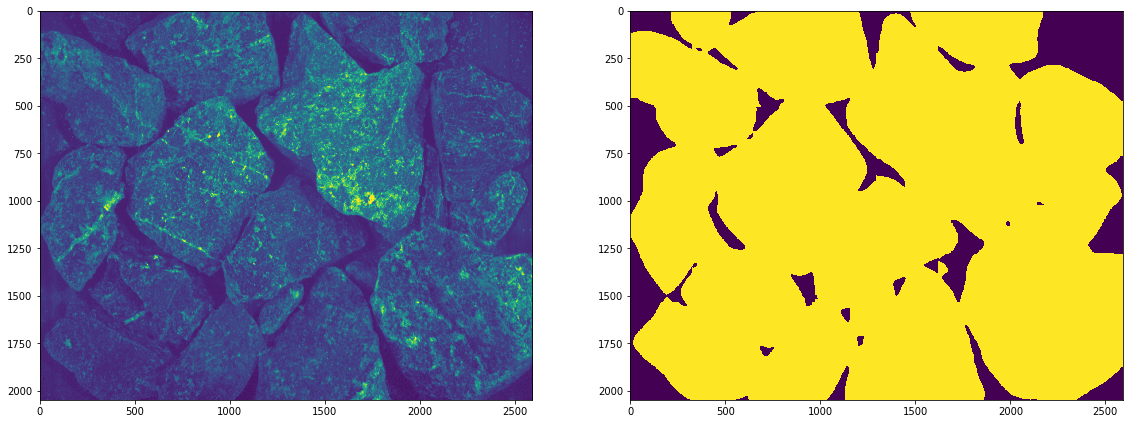

In [13]:
path_img = 'asbest/tr_stones/13_12:04:15_16-03-2020_1.png'
img = cv2.imread(path_img, cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
mask = big_image_predict(model_load, img, crop_size = (img.shape[1] // 4, img.shape[0] // 4), inp_size = (224,224))
plt.figure(figsize=(30,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(np.clip(mask, 0, 1) > 0.5)
plt.savefig(path_img.split('/')[-1].split('_')[0] + '.png', dpi=100, bbox_inches='tight', pad_inches=0)